In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from scipy import stats

# visual style
sns.set(style="whitegrid")
# declutter warnings
warnings.filterwarnings("ignore")

In [2]:
# Load Data and Quick Clean

# load data
data = pd.read_csv('../data/raw/TWOSIDES.csv', nrows=1000000, low_memory=False)

# remove columns we don't care about and rename columns for ease
data = data.rename(columns={
    'drug_1_concept_name': 'drug_1',
    'drug_2_concept_name': 'drug_2',
    'condition_concept_name': 'condition'})
necessary_columns = ['drug_1', 'drug_2', 'condition', 'PRR', 'PRR_error', 'mean_reporting_frequency']
data = data[necessary_columns]

# remove 'drug_1/2_concept_name' from rows
data = data[
    ~data['drug_1'].str.contains('concept_name', case=False, na=False) &
    ~data['drug_2'].str.contains('concept_name', case=False, na=False)
]

In [3]:
# Data Overview

print(f'Columns:\n{data.columns.tolist()}\n')

print(f'Shape: {data.shape[0]} rows x {data.shape[1]} columns\n')
print(f'Columns:\n{data.columns.tolist()}\n')
print(f'Data Types:\n{data.dtypes}\n')

# missing values
missing = data.isnull().sum()

if missing.sum() == 0:
    print('no missing values.')

Columns:
['drug_1', 'drug_2', 'condition', 'PRR', 'PRR_error', 'mean_reporting_frequency']

Shape: 999999 rows x 6 columns

Columns:
['drug_1', 'drug_2', 'condition', 'PRR', 'PRR_error', 'mean_reporting_frequency']

Data Types:
drug_1                      object
drug_2                      object
condition                   object
PRR                         object
PRR_error                   object
mean_reporting_frequency    object
dtype: object

no missing values.


In [4]:
# Basic Stats

# unique drug count
unique_drug_1 = data['drug_1'].nunique()
unique_drug_2 = data['drug_2'].nunique()
unique_drugs = set(data['drug_1']) | set(data['drug_2'])
unique_count = len(unique_drugs)

print(f'Unique drugs in col 1: {unique_drug_1}')
print(f'Unique drugs in col 2: {unique_drug_2}')
print(f'Total  drugs: {unique_count}')

# interaction counts
drug_count = pd.concat([
    data['drug_1'].value_counts(),
    data['drug_2'].value_counts()]).groupby(level=0).sum()

# per drug interactions
print(f'Mean interactions: {drug_count.mean():.2f}')
print(f'Median interactions: {drug_count.median():.2f}')
print(f'Standard deviation: {drug_count.std():.2f}')
print(f'Minimum interactions: {drug_count.min():.2f}')
print(f'Maximum interactions: {drug_count.max():.2f}')


Unique drugs in col 1: 984
Unique drugs in col 2: 1078
Total  drugs: 1317
Mean interactions: 1518.60
Median interactions: 363.00
Standard deviation: 2879.88
Minimum interactions: 1.00
Maximum interactions: 23703.00


In [5]:
# Basic Frequency Analysis

drug_1_count = data['drug_1'].value_counts()
drug_2_count = data['drug_2'].value_counts()
total_drug_count = pd.concat([drug_1_count, drug_2_count]).groupby(level=0).sum()

# list top 25 
print(f'\nMost Interactive Drugs:')
top_25 = total_drug_count.nlargest(25)
print(f"{'Rank':<6} {'Drug Name':<40} {'Interactions':>12}")
for rank, (drug, count) in enumerate(top_25.items(), 1):
    print(f'{rank:<6} {drug:<40} {count:>12,}')

# list bottom 25 
bot_25 = total_drug_count.nsmallest(25)
print(f'\nLeast Interactive Drugs:')
print(f"{'Rank':<6} {'Drug Name':<40} {'Interactions':>12}")
for rank, (drug, count) in enumerate(bot_25.items(), 1):
    print(f'{rank:<6} {drug:<40} {count:>12,}')


Most Interactive Drugs:
Rank   Drug Name                                Interactions
1      Prednisone                                     23,703
2      Aspirin                                        21,349
3      Furosemide                                     20,704
4      Amlodipine                                     20,390
5      Potassium Chloride                             19,585
6      atorvastatin                                   19,378
7      levothyroxine                                  19,257
8      Oxycodone                                      19,108
9      zolpidem                                       18,655
10     Folic Acid                                     15,700
11     pantoprazole                                   15,541
12     Omeprazole                                     15,095
13     gabapentin                                     15,048
14     Metoprolol                                     14,933
15     Simvastatin                                    14,375

In [6]:
# Specific Interaction Patterns
pair_counts = data.groupby(['drug_1', 'drug_2']).size().sort_values(ascending=False)

for i, ((drug_1, drug_2), count) in enumerate(pair_counts.head(25). items(), 1):
    print(f'{i:2d}. {drug_1:} - {drug_2}: {count} interactions')


 1. Aspirin - atorvastatin: 5579 interactions
 2. Ribavirin - peginterferon alfa-2a: 4015 interactions
 3. Amlodipine - levothyroxine: 3991 interactions
 4. Furosemide - Albuterol: 3949 interactions
 5. Acetaminophen - zolpidem: 3891 interactions
 6. Oxycodone - Omeprazole: 3115 interactions
 7. atorvastatin - Prednisone: 3028 interactions
 8. Amlodipine - Folic Acid: 2906 interactions
 9. Hydrocodone - Morphine: 2744 interactions
10. Lisinopril - zolpidem: 2683 interactions
11. Furosemide - Methylprednisolone: 2439 interactions
12. Calcium Carbonate - Prednisone: 2425 interactions
13. Paroxetine - levothyroxine: 2420 interactions
14. prednisolone - adalimumab: 2418 interactions
15. Citalopram - gabapentin: 2411 interactions
16. Amlodipine - Methotrexate: 2391 interactions
17. Esomeprazole - Clonazepam: 2331 interactions
18. oxaliplatin - Leucovorin: 2324 interactions
19. Simvastatin - Calcium: 2316 interactions
20. pantoprazole - Dexamethasone: 2305 interactions
21. Folic Acid - Potas

In [7]:
# Basic Statistical Tests

# normality
stat, p_value = stats.shapiro(total_drug_count.sample(min(5000, len(total_drug_count))))
print(f"   Statistic: {stat:.4f}")
print(f"   P-value: {p_value:.4e}")

skewness = total_drug_count.skew()
kurtosis = total_drug_count.kurt()

print(f'   Skewness: {skewness:.4f}')
print(f'   Kurtosis: {kurtosis:.4f}')

print(f' High skewness (>1) here means that few drugs have many interactions.')
print(f' High Kurtosis value (>3) here means there is many outliers.')


   Statistic: 0.5571
   P-value: 2.0429e-49
   Skewness: 3.5286
   Kurtosis: 15.6146
 High skewness (>1) here means that few drugs have many interactions.
 High Kurtosis value (>3) here means there is many outliers.


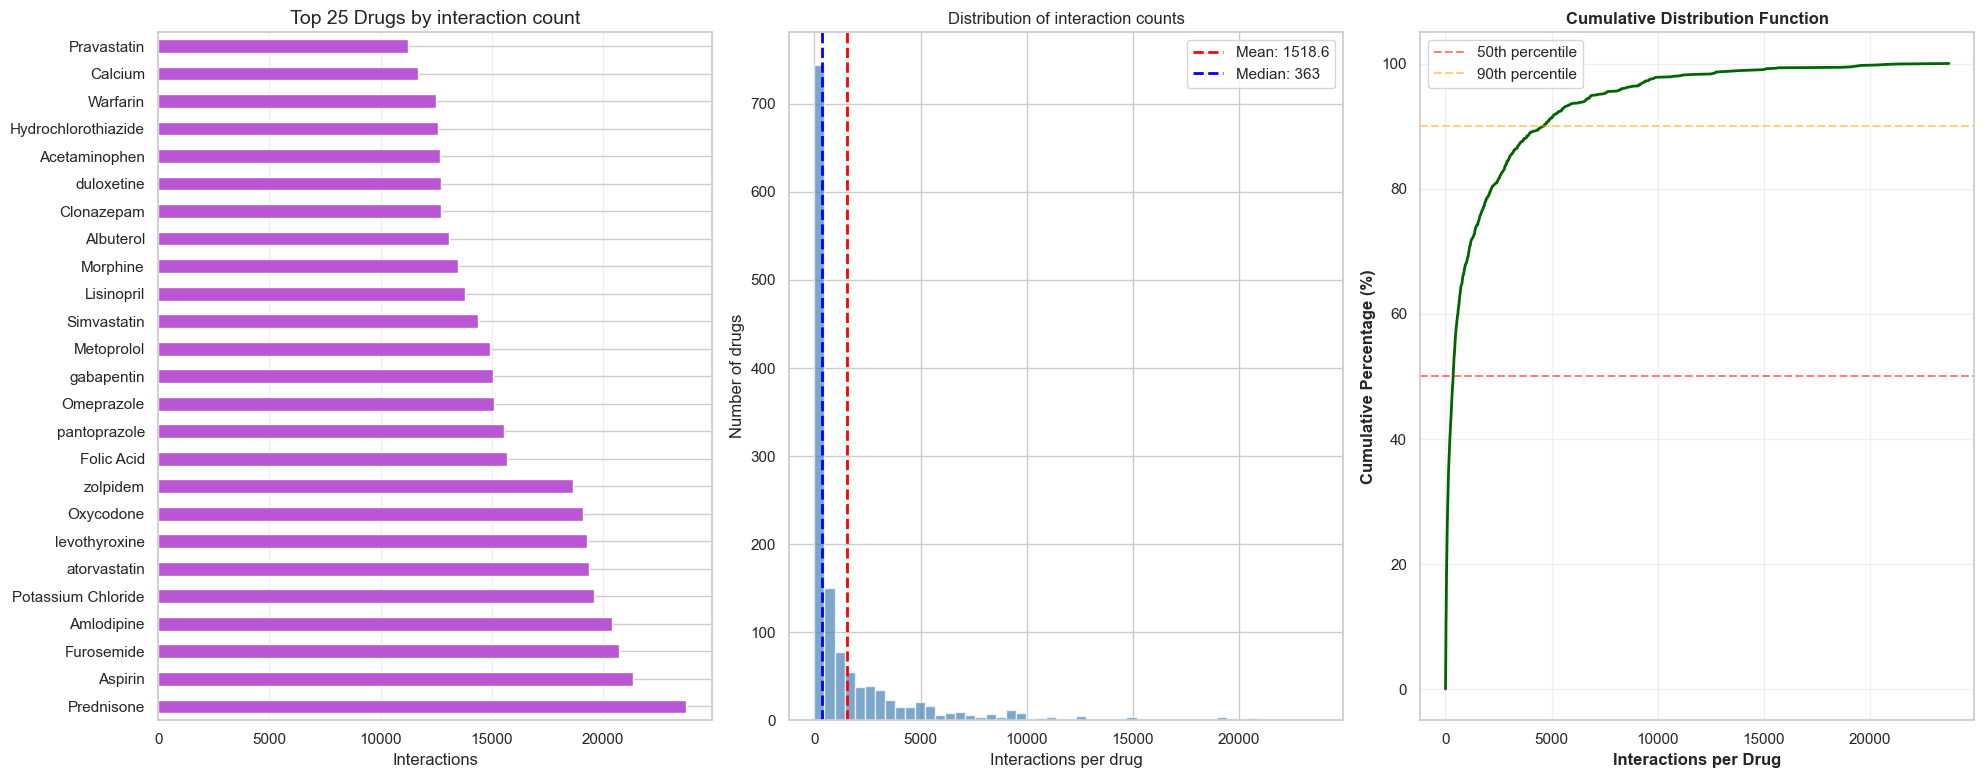

In [38]:
# Visualizations

figure = plt.figure(figsize=(20, 15))

# top drug bar chart
chart1 = plt.subplot(2, 3, 1)
top_25.plot(kind='barh', ax=chart1, color='mediumorchid')
chart1.set_xlabel('Interactions')
chart1.set_title('Top 25 Drugs by interaction count', fontsize=14)
chart1.grid(axis='x', alpha=0.3)

# distribution histo
chart2 = plt.subplot(2, 3, 2)
chart2.hist(total_drug_count, bins=50, color='steelblue', alpha=0.7)
chart2.axvline(total_drug_count.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {total_drug_count.mean():.1f}')
chart2.axvline(total_drug_count.median(), color='blue', linestyle='--', linewidth=2, label=f'Median: {total_drug_count.median():.0f}')
chart2.set_xlabel('Interactions per drug')
chart2.set_ylabel('Number of drugs')
chart2.set_title('Distribution of interaction counts')
chart2.legend()

# distribution
chart3 = plt.subplot(2, 3, 3)
sorted_counts = np.sort(total_drug_count)
cumulative = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts) * 100
chart3.plot(sorted_counts, cumulative, linewidth=2, color='darkgreen')
chart3.axhline(50, color='red', linestyle='--', alpha=0.5, label='50th percentile')
chart3.axhline(90, color='orange', linestyle='--', alpha=0.5, label='90th percentile')
chart3.set_xlabel('Interactions per Drug', fontweight='bold')
chart3.set_ylabel('Cumulative Percentage (%)', fontweight='bold')
chart3.set_title('Cumulative Distribution Function', fontweight='bold', fontsize=12)
chart3.legend()
chart3.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/initial-eda-charts.png', dpi=300, bbox_inches='tight')
plt.show()

# heatmap


In [ ]:
# Initial Conclusions